# Continuing Keras notebooks
When working on large deep learning projects, it is possible that training a single model takes many hours. However, this may be too long for running a model on Google Colab, which offers [no guarantees](https://research.google.com/colaboratory/faq.html) on how long a notebook is allowed to run. This means that after training for a few hours, the **runtime may suddenly stop and delete all local variables, including the model and the training history!** 

This notebook therefore shows how you can exploit advanced tf.keras functionalities to maintain a backup of your model and resume incomplete training runs. 



### Import some libraries

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras.
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries.
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, History
from tensorflow.keras.callbacks.experimental import BackupAndRestore

2.4.1


In [ ]:
# Mount the Google Drive file system.
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Define an example setup

In [ ]:
# Load MNIST dataset.
(x_train_all, r_train_all_class), (x_test, r_test_class) = mnist.load_data()
x_train_all = x_train_all.reshape(x_train_all.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

x_train_all = x_train_all.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Split train set into train/validation set.
N_val = 10000
N_train = x_train_all.shape[0] - N_val
x_train, x_val, r_train_class, r_val_class = train_test_split(x_train_all, r_train_all_class, test_size = N_val, random_state=0)

# Convert all labels to one-hot encoding.
r_train_all = keras.utils.to_categorical(r_train_all_class)
r_train = keras.utils.to_categorical(r_train_class)
r_val = keras.utils.to_categorical(r_val_class)
r_test = keras.utils.to_categorical(r_test_class)

N_classes = r_train.shape[1]

In [ ]:
# Define a simple model.
def build_model():
  model = Sequential()
  model.add(Dense(16, activation='relu', input_shape=(784,), kernel_initializer='he_uniform'))
  model.add(Dense(N_classes, activation='softmax'))
  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                12560     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                170       
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Some training parameters.
batch_size = 16
total_nb_epochs = 10  # The total number of epochs that you want to run the fit() function.
monitor = 'val_accuracy'  # The measure for the 'best' model. The default is 'val_loss'.

### Model checkpoints
The tf.keras library has many options for saving and loading models. The most basic one is the ModelCheckpoint callback, which saves the entire model (including weights, optimizer state, ...) in the specified '.h5' file. For example, this callback can be used to automatically save the model that scores the best on the 'monitor' metric, e.g. the 'val_accuracy'.

As stated previously, a possible issue is that your runtime may be interrupted before the training epochs are over. TensorFlow has therefore recently introduced the BackupAndRestore callback, which automatically maintains the *latest* state of the model as a backup. When executing an interrupted training run, this callback will allow you to resume from the epoch of that latest model. **Warning: this backup is deleted from the disk after all training epochs are completed!**

In [ ]:
# The directory where we can save the best models and the temporary backups. 
# Also, the training history and temporary states of the model will be saved here.
checkpoint_dir = "/content/gdrive/My Drive/Colab Notebooks/DL2020/continuing/"

# Create a callback that saves the latest model.
backup_callback = BackupAndRestore(checkpoint_dir + "backup/")

# Create a callback that saves the best model so far.
best_cp_callback = ModelCheckpoint(checkpoint_dir+"best_model.h5",
                                   monitor=monitor,
                                   save_weights_only=False,
                                   save_best_only=True,
                                   verbose=1)

Try to run the model.fit code below and interrupt the process by clicking the cell's 'stop' button or clicking on 'Runtime' > 'Interrupt execution'. Then click 'Runtime' > 'Restart runtime' to wipe the memory of the notebook (this simulates what happens if your notebook disconnects completely). Afterwards, run the previous cells again.

In [ ]:
history = model.fit(x_train, r_train,
          batch_size=batch_size,
          epochs=total_nb_epochs,
          verbose=1,
          callbacks = [best_cp_callback, backup_callback],
          validation_data=(x_val, r_val),
          )

Epoch 3/10
3125/3125 [==============================] - 5s 1ms/step - loss: 0.2409 - accuracy: 0.9327 - val_loss: 0.2252 - val_accuracy: 0.9350

Epoch 00003: val_accuracy improved from -inf to 0.93500, saving model to /content/gdrive/My Drive/Colab Notebooks/DL2020/continuing/best_model.h5
Epoch 4/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.2179 - accuracy: 0.9371 - val_loss: 0.2116 - val_accuracy: 0.9364

Epoch 00004: val_accuracy improved from 0.93500 to 0.93640, saving model to /content/gdrive/My Drive/Colab Notebooks/DL2020/continuing/best_model.h5
Epoch 5/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.2042 - accuracy: 0.9406 - val_loss: 0.1989 - val_accuracy: 0.9403

Epoch 00005: val_accuracy improved from 0.93640 to 0.94030, saving model to /content/gdrive/My Drive/Colab Notebooks/DL2020/continuing/best_model.h5
Epoch 6/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.1886 - accuracy: 0.9457 - val_loss: 0.1894 

In [ ]:
# Normally, the backup is deleted automatically after all training epochs have ended. 
# Executing this command forces the deletion even if the training is not done yet.
!rm -r "{checkpoint_dir + "backup/"}"

# Use the line below to reset the model in memory as well.
# model = build_model()

You will notice that the model training indeed continues from the last succesful epoch.

However, when the memory is wiped, the 'best model' callback no longer knows what the val_accuracy was of the previously best model! Instead, the internal state of the callback is reset, and it thinks that the previously best score was '-inf'. Similarly, the actual history is not saved automatically, which makes it impossible to plot the full validation curve:

Number of history entries: 8


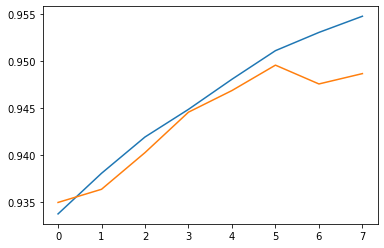

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
print(f"Number of history entries: {len(history.history['loss'])}")

### History backup
To make sure we save other information, we need to write additional backup code. Below is an example of how the History callback can be extended to automatically save the training history to a pickle file.

In [ ]:
import pickle
import os

class HistoryCheckpoint(History):
  def __init__(self, pickle_path, monitor):
    """
    A custom callback that saves the training history to a pickle file after
    every epoch.
    Arguments:
      pickle_path: the path of where the history should be stored.
      monitor: the value that indicates what the 'best' model is.
    """
    super().__init__()
    self.pickle_path = pickle_path
    self.monitor = monitor
    self.is_resuming = False

  def load_history(self):
    """
    Try to open the history file at the given pickle_path.
    """
    with open(self.pickle_path, "rb") as file:
      self.history = pickle.load(file)
      self.epoch = [i for i in range(len(self.history['loss']))]
      self.is_resuming = True
      

  def on_train_begin(self, logs=None):
    # If not already resuming from a loaded history, then initialize all
    # fields using the code from the History callback.
    if not self.is_resuming:
      super().on_train_begin(logs)

  def on_epoch_end(self, epoch, logs=None):
    # Update the history according to the functionality of History.
    super().on_epoch_end(epoch, logs)

    # Save the history to a pickle file.
    with open(self.pickle_path, "wb") as file:
      pickle.dump(self.history, file)

  def on_train_end(self, logs=None):
    os.remove(self.pickle_path)


# Intitialize a HistoryCheckpoint.
history_callback = HistoryCheckpoint(checkpoint_dir + "history.pi", 
                                     monitor=monitor)
# Reset the other callbacks.
backup_callback = BackupAndRestore(checkpoint_dir + "backup/")
best_cp_callback = ModelCheckpoint(checkpoint_dir+"best_model.h5", 
                                   monitor=monitor,
                                   save_weights_only=False,
                                   save_best_only=True,
                                   verbose=1)

# Reset the model.
model = build_model()

try:
  # Try to resume from a history.
  history_callback.load_history()

  # Set the best value from this history in the 'best model' callback.
  if best_cp_callback.monitor_op == np.less:
    best_cp_callback.best = np.min(history_callback.history[monitor])
  if best_cp_callback.monitor_op == np.greater:
    best_cp_callback.best = np.max(history_callback.history[monitor])
  print(f"History with {len(history_callback.epoch)} epochs loaded!")
except OSError:
  print("No history found, starting new logs!")

# Fit the model.
model.fit(x_train, r_train,
          batch_size=batch_size,
          epochs=total_nb_epochs,
          verbose=1,
          callbacks = [history_callback, best_cp_callback, backup_callback],
          validation_data=(x_val, r_val)
          )
history = history_callback
print(f"Number of history entries: {len(history.history['loss'])}")

History with 4 epochs loaded!
Epoch 5/10
3125/3125 [==============================] - 5s 1ms/step - loss: 0.1771 - accuracy: 0.9499 - val_loss: 0.1860 - val_accuracy: 0.9487

Epoch 00005: val_accuracy improved from 0.94590 to 0.94870, saving model to /content/gdrive/My Drive/Colab Notebooks/DL2020/continuing/best_model.h5
Epoch 6/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.1632 - accuracy: 0.9541 - val_loss: 0.1796 - val_accuracy: 0.9503

Epoch 00006: val_accuracy improved from 0.94870 to 0.95030, saving model to /content/gdrive/My Drive/Colab Notebooks/DL2020/continuing/best_model.h5
Epoch 7/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.1558 - accuracy: 0.9552 - val_loss: 0.1793 - val_accuracy: 0.9482

Epoch 00007: val_accuracy did not improve from 0.95030
Epoch 8/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.1503 - accuracy: 0.9570 - val_loss: 0.1691 - val_accuracy: 0.9509

Epoch 00008: val_accuracy improved fr

In [ ]:
# Again, the history will be removed after a full training run automatically,
# but you can force the history to be deleted to be sure:
!rm -r "{checkpoint_dir + "history.pi"}"

rm: cannot remove '/content/gdrive/My Drive/Colab Notebooks/DL2020/continuing/history.pi': No such file or directory


Number of history entries: 10


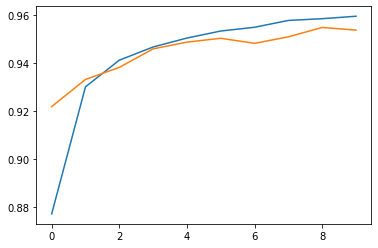

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
print(f"Number of history entries: {len(history.history['loss'])}")

### Further extensions
The above code covers the standard use case, but you may run into some unexpected behaviour when using other callbacks, such as EarlyStopping or LearningRateScheduler. Without modifications, they will not be aware that you are resuming training!

You can write your own callbacks, but it should already be clear that writing resumable code is tricky and requires a good overview of how information is stored in Keras. It can therefore be useful to dive into the [source code](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/keras/callbacks.py) of current Keras callbacks. Obviously, this requires advanced knowledge of Python.

Alternatively, you can ask us for help on Teams if you have questions about this notebook or a specific use case. 